In [16]:
from chess_evaluator import evaluate_board, piece_values
import chess
import random
import time 
import matplotlib.pyplot as plt
import numpy as np

In [17]:
piece_to_unicode = {
    chess.PAWN: '♙', chess.KNIGHT: '♘', chess.BISHOP: '♗',
    chess.ROOK: '♖', chess.QUEEN: '♕', chess.KING: '♔',
    -chess.PAWN: '♟', -chess.KNIGHT: '♞', -chess.BISHOP: '♝',
    -chess.ROOK: '♜', -chess.QUEEN: '♛', -chess.KING: '♚'
}

In [9]:
def score_move(board, move):
    """
    Scores moves based on heuristics to improve move ordering.
    Higher scores indicate better moves.
    """
    score = 0

    # Prioritize captures using MVV-LVA (Most Valuable Victim - Least Valuable Attacker)
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        if captured_piece:
            attacker = board.piece_at(move.from_square)
            score += 10 * piece_values[captured_piece.piece_type] - piece_values[attacker.piece_type]

    # Prioritize promotions
    if move.promotion:
        score += 800  # High score for promotions

    # Prioritize checks
    board.push(move)
    if board.is_check():
        score += 50
    board.pop()

    # Penalize moves that hang a piece
    board.push(move)
    if board.is_attacked_by(not board.turn, move.to_square):
        if not board.is_attacked_by(board.turn, move.to_square):
            # The piece is hanging
            score -= piece_values[board.piece_type_at(move.to_square)]
    board.pop()

    return score


In [11]:
killer_moves = {}

def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)

    global killer_moves
    killer_move = killer_moves.get(depth)

    if maximizing_player:
        max_eval = -float('inf')
        moves = list(board.legal_moves)

        # Place the killer move at the front if it exists
        if killer_move in moves:
            moves.remove(killer_move)
            moves.insert(0, killer_move)

        moves.sort(key=lambda move: score_move(board, move), reverse=True)

        for move in moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            if eval > max_eval:
                max_eval = eval
                if eval > alpha:
                    alpha = eval
                    # Update killer move
                    killer_moves[depth] = move
            if beta <= alpha:
                break  # Beta cutoff
        return max_eval
    else:
        min_eval = float('inf')
        moves = list(board.legal_moves)

        # Place the killer move at the front if it exists
        if killer_move in moves:
            moves.remove(killer_move)
            moves.insert(0, killer_move)

        moves.sort(key=lambda move: score_move(board, move), reverse=True)

        for move in moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            if eval < min_eval:
                min_eval = eval
                if eval < beta:
                    beta = eval
                    # Update killer move
                    killer_moves[depth] = move
            if beta <= alpha:
                break  # Alpha cutoff
        return min_eval


In [15]:
def select_best_move(board, depth):
    """
    Selects the best move for the bot using minimax with alpha-beta pruning.
    """
    best_move = None
    max_eval = -float('inf')
    alpha = -float('inf')
    beta = float('inf')

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, alpha, beta, False)
        board.pop()

        if eval > max_eval:
            max_eval = eval
            best_move = move

    return best_move

In [21]:
def draw_chessboard(ax, board):
    # Create an 8x8 board
    chessboard = np.zeros((8, 8, 3))
    colors = [(1, 1, 1), (0.7, 0.7, 0.7)]  # White and gray

    # Draw the checkerboard pattern
    for x in range(8):
        for y in range(8):
            chessboard[y, x] = colors[(x + y) % 2]

    ax.imshow(chessboard, origin='upper')

    # Add pieces to the chessboard
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_type = piece.piece_type if piece.color == chess.WHITE else -piece.piece_type
            ax.text(chess.square_file(square), 7 - chess.square_rank(square), piece_to_unicode[piece_type],
                    fontsize=40, ha='center', va='center')

    # Add ranks (1-8) and files (a-h)
    for i in range(8):
        ax.text(-0.5, 7 - i, str(i + 1), ha='center', va='center', fontsize=12)
        ax.text(i, 8, chr(i + ord('a')), ha='center', va='center', fontsize=12)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(-0.5, 8.5)

def display_board(board, evaluation):
    fig, ax = plt.subplots(figsize=(6, 6))
    draw_chessboard(ax, board)
    ax.set_title(f"Board Evaluation: {evaluation:.2f}")
    plt.show(block=False)
    plt.pause(0.1)

In [22]:
def play_game():
    board = chess.Board()
    depth = 3  # Set the desired depth

    print("Starting Game:")
    plt.ion()  # Turn on interactive mode for real-time updates

    while not board.is_game_over():
        # Display whose turn it is
        if board.turn == chess.WHITE:
            print("\nWhite's move (Bot):")
            move = select_best_move(board, depth)
        else:
            print("\nBlack's move (Random):")
            move = random.choice(list(board.legal_moves))

        # Make the move
        board.push(move)

        # Real-time evaluation of the position
        evaluation = evaluate_board(board)

        # Display the updated board with evaluation
        display_board(board, evaluation)

        # Add a delay for better real-time visualization effect
        time.sleep(1)  # Adjust the sleep time as per preference

    # Display final game result
    print("\nGame Over!")
    result = board.result()
    print(f"Result: {result}")
    plt.ioff()  # Turn off interactive mode
    plt.show()  # Keep the final board displayed

Starting Game:

White's move (Bot):


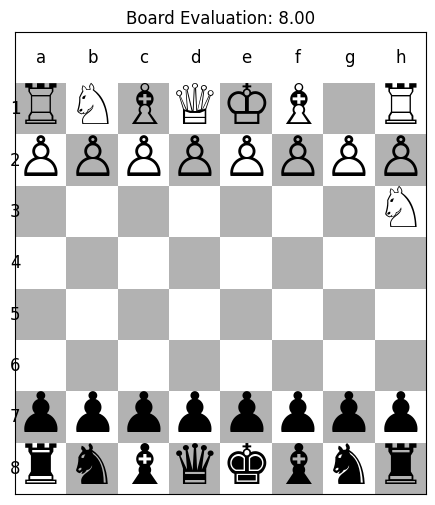


Black's move (Random):


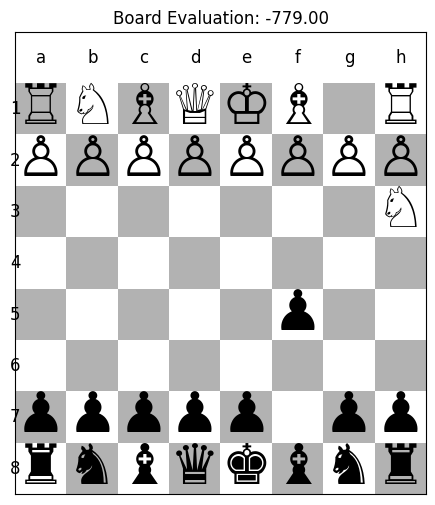


White's move (Bot):


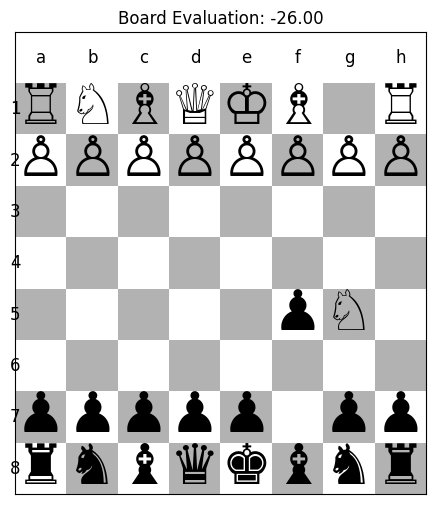


Black's move (Random):


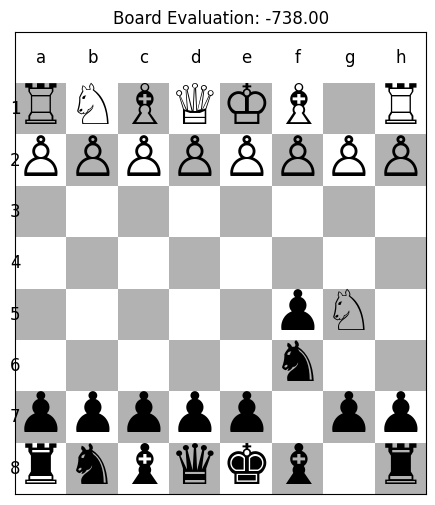


White's move (Bot):


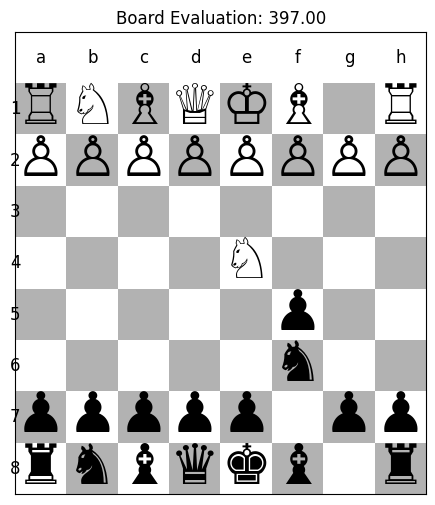


Black's move (Random):


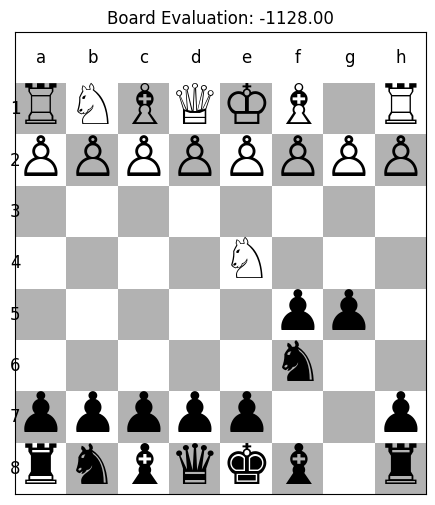


White's move (Bot):


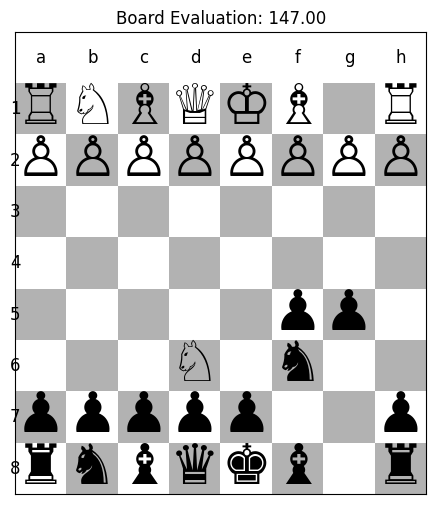


Black's move (Random):


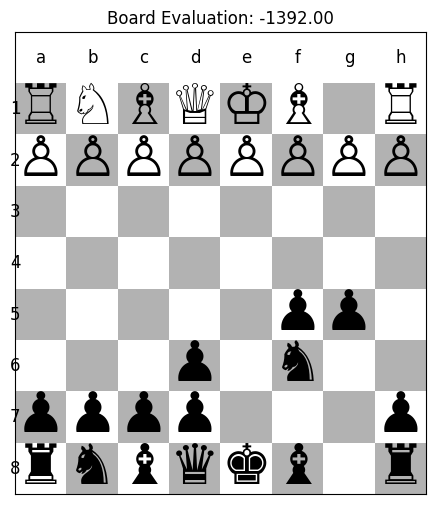


White's move (Bot):


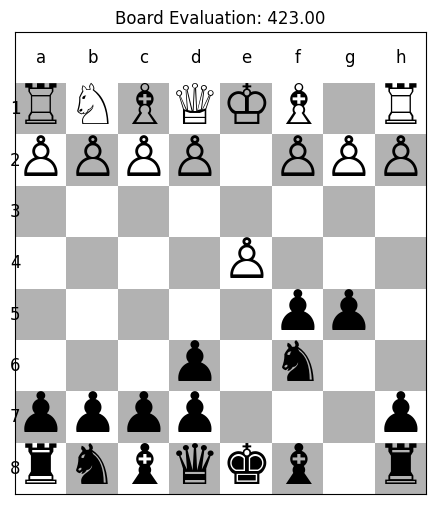


Black's move (Random):


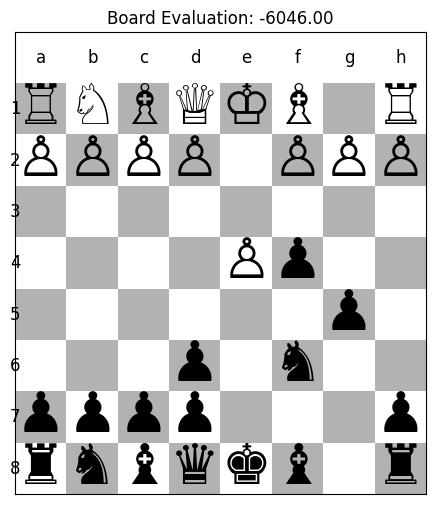


White's move (Bot):


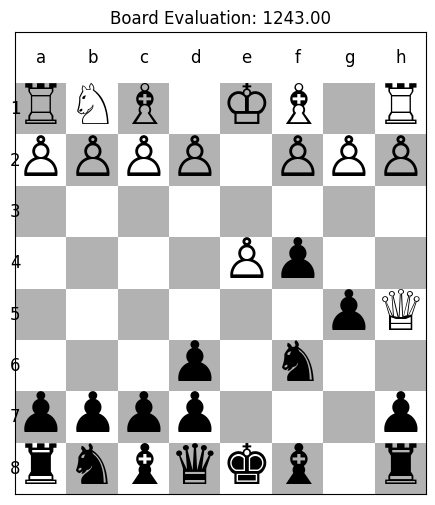


Black's move (Random):


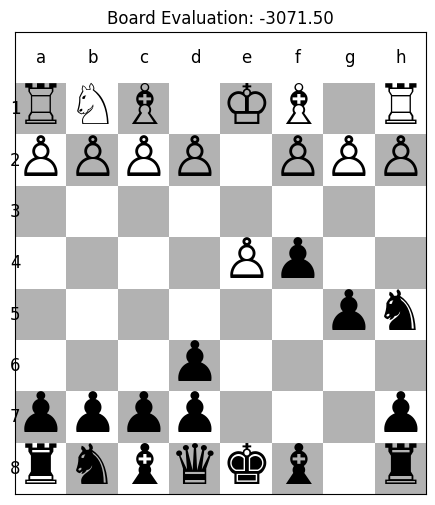


White's move (Bot):


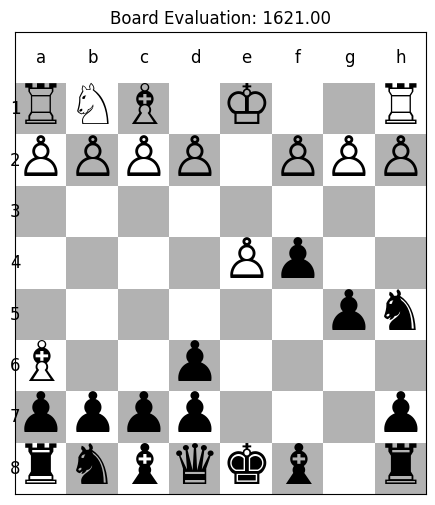


Black's move (Random):


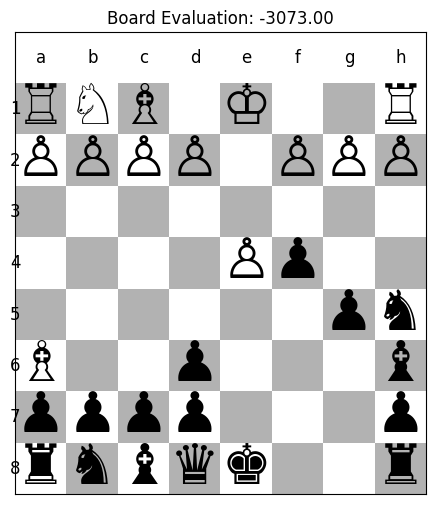


White's move (Bot):


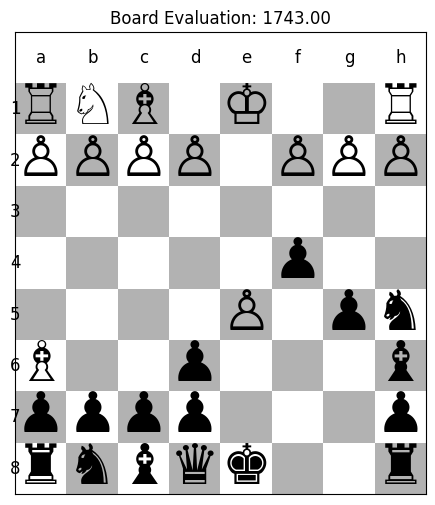


Black's move (Random):


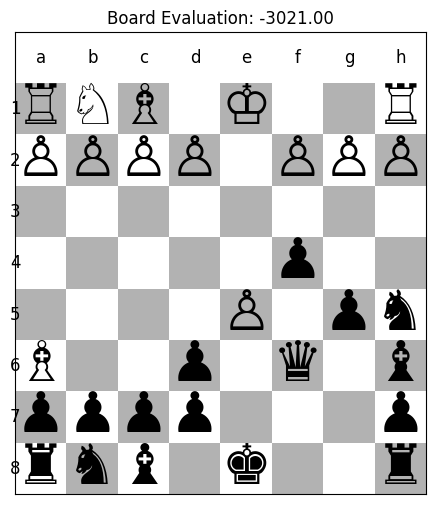


White's move (Bot):


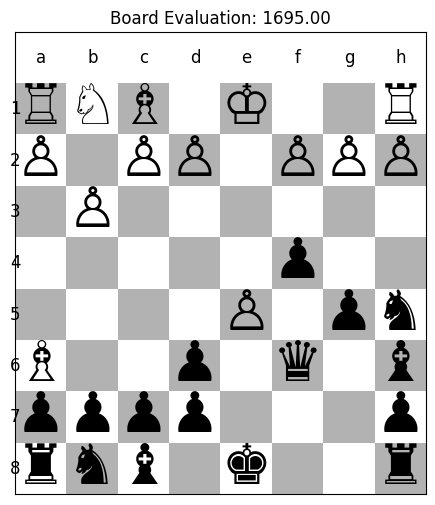


Black's move (Random):


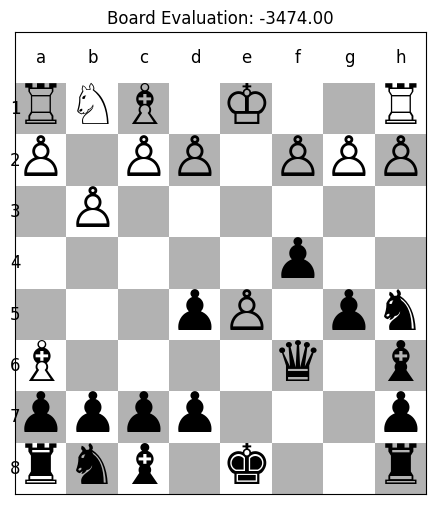


White's move (Bot):


KeyboardInterrupt: 

In [23]:
play_game()